In [3]:
import sys
sys.path.insert(0, "../")

In [2]:
import matplotlib.pyplot as plt

from experiments.data_visualisation import fetch_and_aggregate_experiment_data

# BERT training

In [4]:
line_styles = [("--", "o"), ("-", "o"), ("-.", "o"), (":", "o"),
               ("--", "s"), ("-", "s"), ("-.", "s"), (":", "s")]


def plot_data(data_to_plot, num_epochs, data_key, trial_label_generator=None):
    data_to_plot = [
        (trial_name if trial_label_generator is None else 
             trial_label_generator(data["trial_name"], data["hyperparameters"]), 
         data) for data in data_to_plot]
    data_to_plot.sort()

    for (label, data), (line, marker) in zip(data_to_plot, line_styles):        
        y = data[data_key][:num_epochs]
        plt.plot(
            range(1, len(y)+1), y,
            label=label,
            marker=marker,
            linestyle=line,
        )
        plt.xlabel("Epoch")
        plt.legend()

        
def preprocess_label(t, hp):
    return {
        "[remove_emojis]": "-emojis",
        "[remove_emojis, remove_punctuation]": "-emojis, -punctuation",
        "[remove_emojis, remove_tags]": "-emojis, -tags",
        "[remove_emojis, remove_tags, remove_punctuation]": "-emojis, -tags, -punctuation",
        "[tag_emojis]": "[emojis]",
        "[tag_emojis, remove_punctuation]": "[emojis], -punctuation",
        "[replace_emojis_no_sep]": "+emojis",
        "[replace_emojis_no_sep, remove_tags]": "+emojis, -tags",
        "[replace_emojis_no_sep, remove_tags, remove_punctuation]": "+emojis, -tags, -punctuation",
        "none": "No preprocessing",
    }[hp.get('Bert.preprocessing')]


def encoder_outputs_label(t, hp):
    return {
        "default": "Last layer",
        "2nd_to_last_hidden_layer": "2nd-to-last layer",
        "sum_all_hidden_layers": "Sum all layers",
        "sum_last_4_hidden_layers": "Sum last 4 layers",
        "concat_last_4_hidden_layers": "Concatenate last 4 layers",
    }[hp.get('selected_encoder_outputs')]


def pooler_label(t, hp):
    return {
        "max": "Max",
        "concat": "Concatenate",
        "average": "Average"
    }[hp.get('Bert.pooler')]


def kernel_reg_label(t, hp):
    return f"{hp.get('Bert.dense_kernel_reg')} l2"

## BERT individual HP tuning

### Preprocessing choice

Investigated using the following preprocessing options:
* Replace emojis with their description (e.g. "😂" -> "face with tears of joy") - '+emoji'
* Remove tags ("#URL#", "#HASHTAG#", "#USER#") - '-tag'
* Remove punctuation ("hey! How arre you guys doing??!" -> "hey How are you guys doing") - '-punctuation'

I found that the preprocessing options with the best validation loss were:
* +emojis, -tags
* -emojis, -tags
* -emojis, -tags, -punctuation

This suggests that BERT struggles to learn tags

In [179]:
# Traing on batch_size=32, dropout_rate=0.1, learning_rate=2e-5
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/tweet_level/preprocessing",
    trial_aggregator=lambda hp: hp.get('Bert.preprocessing'),
)

Text(0.5, 1.0, 'Training Loss')

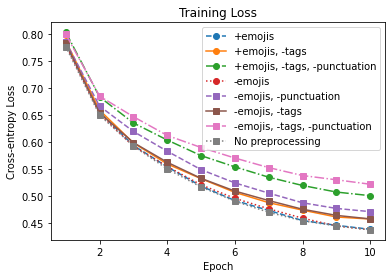

In [180]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=preprocess_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

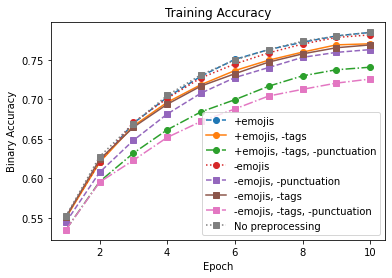

In [181]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=preprocess_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

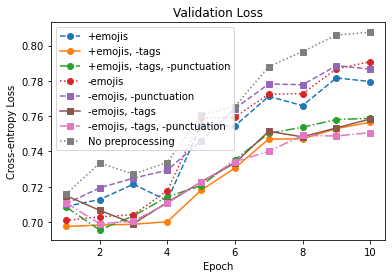

In [182]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=preprocess_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

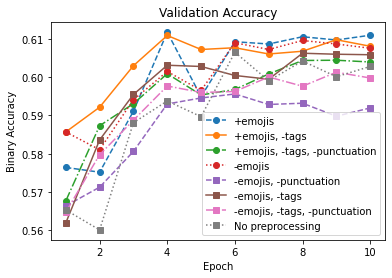

In [183]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=preprocess_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT pooled_output strategy

It has been found that using different strategies to extra layers from BERT have had more success than using BERT's default pooled ouput (the output of the final transformer layer). I investigated using the following strategies:
* Using the 2nd-to-last layer
* Concatenating the last 4 layers
* Using the last layer (BERT's default pooled output)
* Sum all layers
* Sum the last 4 layers

I found that using the last layer provided the steadiest validation loss. This is contrary to other work, which has found fine-tuning problem patterns are more distinct within previous layers. However, the reasoning is most likely that patterns within this data exist across a users tweet feed; as here we are only training on individual tweets, BERT struggles to learn any distinct patterns (the other reason why validation loss tends to be very high and accuracy very low).

In [4]:
# Traing on batch_size=32, dropout_rate=0.1, learning_rate=2e-5, preprocessing=[replace_emojis_no_sep, remove_tags]
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/tweet_level/pooled_output",
    trial_aggregator=lambda hp: hp.get('selected_encoder_outputs'),
)

Text(0.5, 1.0, 'Training Loss')

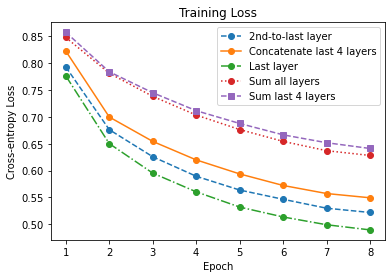

In [5]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=encoder_outputs_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

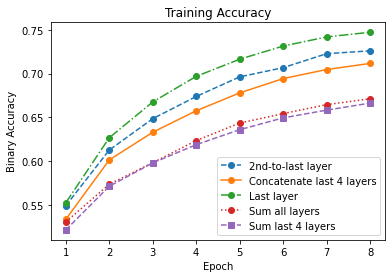

In [6]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=encoder_outputs_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

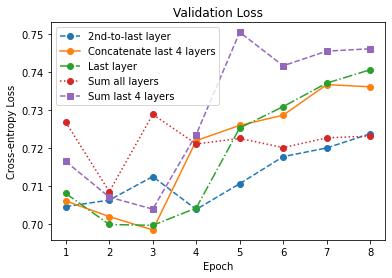

In [7]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=encoder_outputs_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

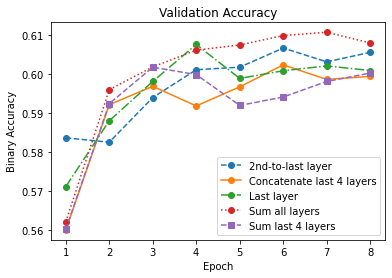

In [8]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=encoder_outputs_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT kernel_reg

Adding regularisation can help to improve the ability of a model to generalise to new data. I explored applying kernel regularisation (regularisation to the trained weights) for the last linear layer of the model.

Overall I found that 0.01 l2 regularisation was too high - resulting in the model struggling more to fit to the data and hence not predicting the validation data well. The best was 1e-5, showing that a small amount of regularisation does help the model to generalise better.

In [40]:
# batch_size=8, dropout_rate=0.1, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/tweet_level/kernel_reg",
    trial_aggregator=lambda hp: hp.get('Bert.dense_kernel_reg'),
)

Text(0.5, 1.0, 'Training Loss')

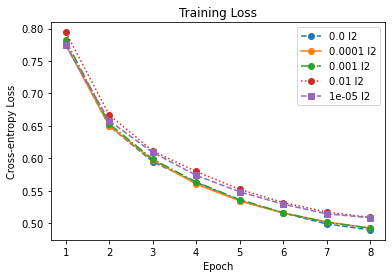

In [47]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=kernel_reg_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

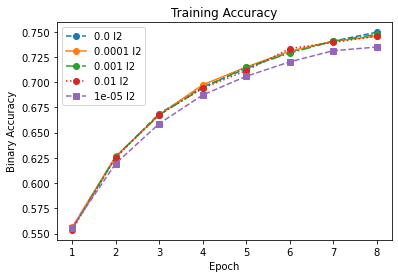

In [48]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=kernel_reg_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

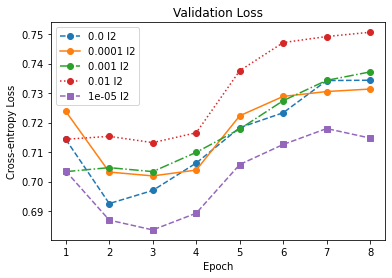

In [49]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=kernel_reg_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

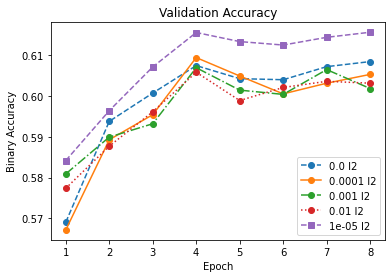

In [50]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=kernel_reg_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

## BERT chunked HP tuning

### Preprocessing choice

I investigated the different preprocessing functions which performed better on the individual BERT model.

I found that removing emojis and tags had the steadiest validation loss.

In [130]:
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/indiv_2",
    trial_aggregator=lambda hp: hp.get('Bert.preprocessing'),
    trial_filterer=lambda t, hp: 
        hp.get("Bert.pooler") == "max" and hp.get("selected_encoder_outputs") == "default",
)

Text(0.5, 1.0, 'Training Loss')

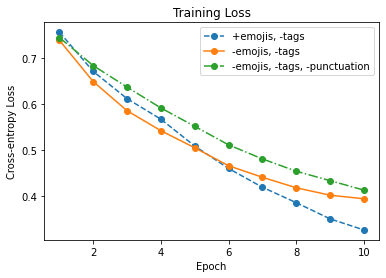

In [131]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=preprocess_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

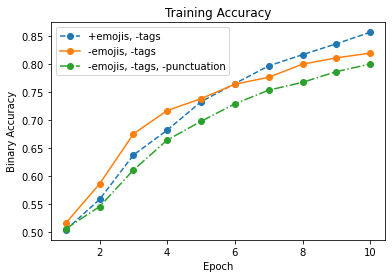

In [132]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=preprocess_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

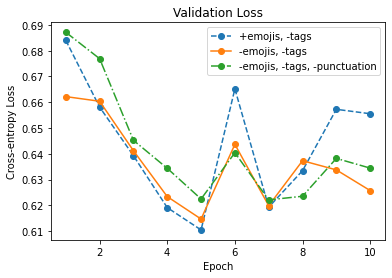

In [133]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=preprocess_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

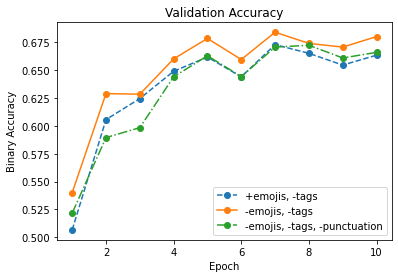

In [134]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=preprocess_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked pooled_output strategy

Once again, I investigated different BERT pooled_output strategies.

I found the opposite to when experimenting with the individual model - using the last layer performe the word. The best results were from summing all of the layers or the last 4 layers, as well as concatenating the last 4 layers. This is most likely due to previous transformer layers fitting different patterns within the data. Due to this chunking model using 10 tweets to make a classification, it is more likely that individual fake tweets will exist within the training data of this model, and thus it is able to fit the patterns of the data much better than the individual model.

In [135]:
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/indiv_2",
    trial_aggregator=lambda hp: hp.get('selected_encoder_outputs'),
    trial_filterer=lambda t, hp: 
        hp.get("Bert.pooler") == "max" and hp.get("Bert.preprocessing") == "[remove_emojis, remove_tags]",
)

Text(0.5, 1.0, 'Training Loss')

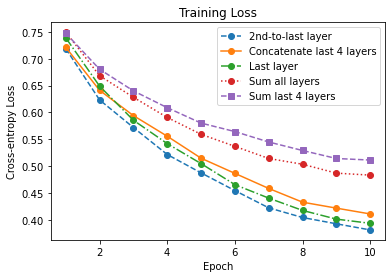

In [136]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=encoder_outputs_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

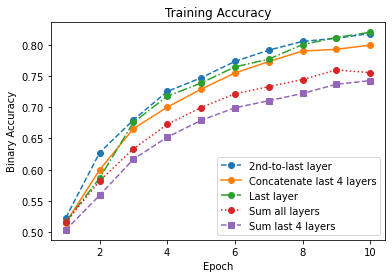

In [137]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=encoder_outputs_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

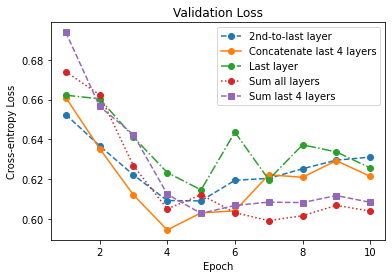

In [138]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=encoder_outputs_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

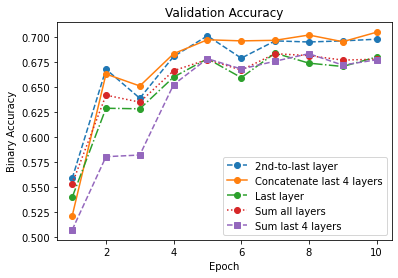

In [139]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=encoder_outputs_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked tweet embeddings pooler

The chunked BERT model embeds 10 different tweets, and then applies a pooling method to these tweets before passing them to a final classification layer. Here I investigate using: average pooling, max pooling, or concatenating the embeddings.

I found that average pooling tends to overfit the data, whereas max pooling and concatenation perform much better. Concatenation seems to provide the steadiest loss.

In [140]:
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/indiv_2",
    trial_aggregator=lambda hp: hp.get('Bert.pooler'),
    trial_filterer=lambda t, hp: 
        hp.get("selected_encoder_outputs") == "sum_all_hidden_layers" and 
        hp.get("Bert.preprocessing") == "[remove_emojis, remove_tags]",
)

Text(0.5, 1.0, 'Training Loss')

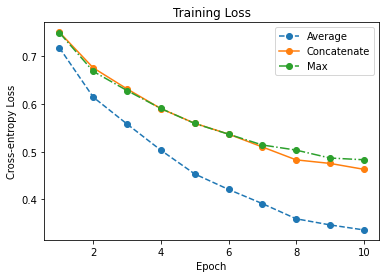

In [141]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=pooler_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

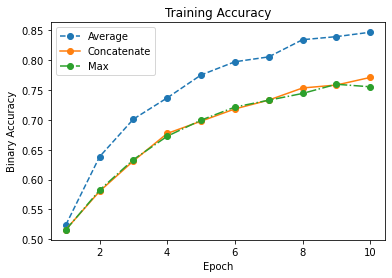

In [142]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=pooler_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

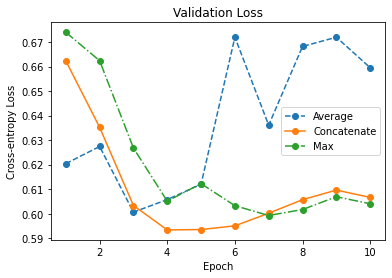

In [143]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=pooler_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

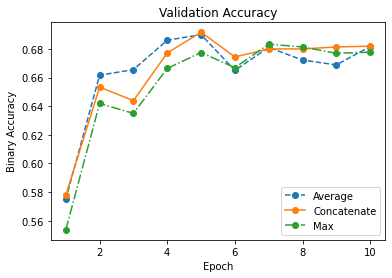

In [144]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=pooler_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### Best BERT chunked models

Through a grid-search on all combinations of: preprocessing, BERT pooled_output strategy, and embedding pooling, I found that the top 3 models were:
* Sum all layers, remove emojis and tags, concatenate BERT embeddings
* Sum all layers, remove emojis and tags, max-pool BERT embeddings
* Sum the last 4 layers, remove emojis and tags, concatenate BERT embeddings

Of these, the two with embedding concatenation pooling strategies performed the best.

In [164]:
def best_chunked_label(t, hp):
    return f"{encoder_outputs_label(t, hp)}, {preprocess_label(t, hp)}, {pooler_label(t, hp)}"


def select_best_models(t, hp):
    pooled_output = hp.get("selected_encoder_outputs")
    preprocessing = hp.get("Bert.preprocessing")
    pooler = hp.get("Bert.pooler")
    
    best_models = {
        "sum_all_hidden_layers [remove_emojis, remove_tags] concat",
        "sum_all_hidden_layers [remove_emojis, remove_tags] max",
        "sum_last_4_hidden_layers [remove_emojis, remove_tags] concat",
    }
    return f"{pooled_output} {preprocessing} {pooler}" in best_models

# dense_activation=linear
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/indiv_2",
    trial_aggregator=lambda hp: best_chunked_label(None, hp),
    trial_filterer=select_best_models,
)

Text(0.5, 1.0, 'Training Loss')

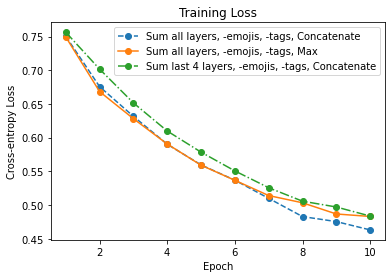

In [172]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=best_chunked_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

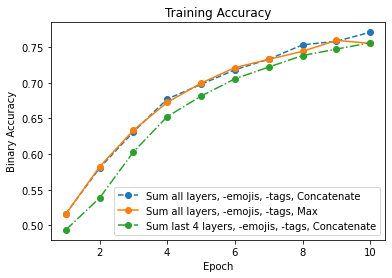

In [171]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=best_chunked_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

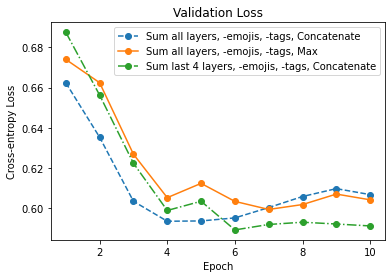

In [170]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=best_chunked_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

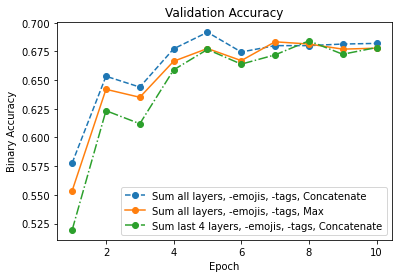

In [169]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=best_chunked_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked kernel regularisation

Explored kernel regularisation like previously.

Same findings as before: 0.01 l2 regularisation means the model struggles to learn; the optimal regularisation is 1e-5 l2.

In [34]:
# batch_size=8, dropout_rate=0.1, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dense_activation=linear
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/kernel_reg",
    trial_aggregator=lambda hp: hp.get('Bert.dense_kernel_reg'),
)

Text(0.5, 1.0, 'Training Loss')

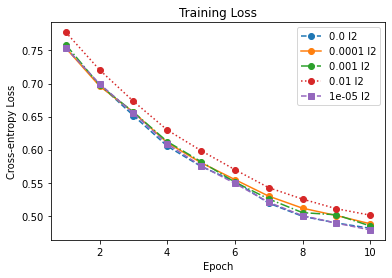

In [35]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=kernel_reg_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

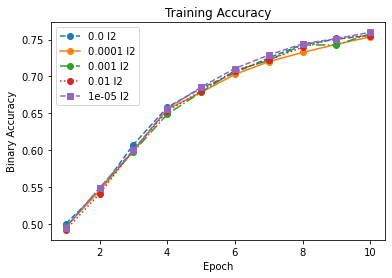

In [36]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=kernel_reg_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

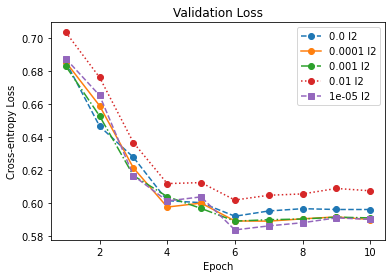

In [37]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=kernel_reg_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

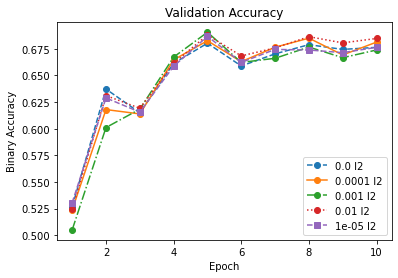

In [38]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=kernel_reg_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT batch norm or no batch norm

In [13]:
def batch_norm_label(t, hp):
    return "Use BatchNorm" if hp.get("Bert.use_batch_norm") else "No BatchNorm"

# batch_size=8, dropout_rate=0.1, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dense_activation=linear
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/batch_norm",
    trial_aggregator=lambda hp: hp.get('Bert.use_batch_norm'),
)

Text(0.5, 1.0, 'Training Loss')

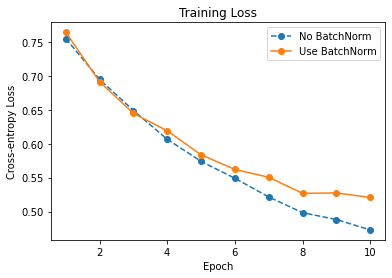

In [14]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=batch_norm_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

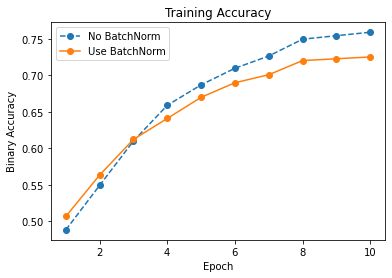

In [15]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=batch_norm_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

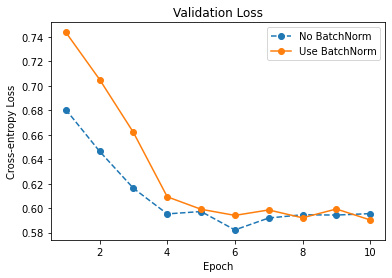

In [16]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=batch_norm_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

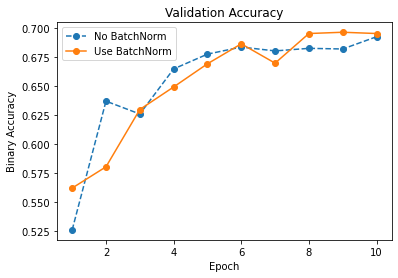

In [17]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=batch_norm_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked final linear layer activation

In [5]:
def dense_activation_label(t, hp):
    return hp.get("Bert.dense_activation")

# batch_size=8, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dense_activation=linear
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/dense_activation",
)

Text(0.5, 1.0, 'Training Loss')

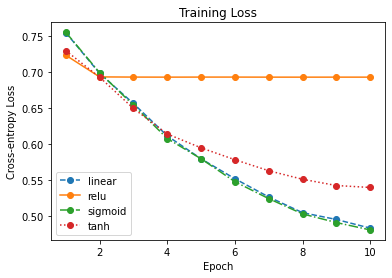

In [6]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=dense_activation_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

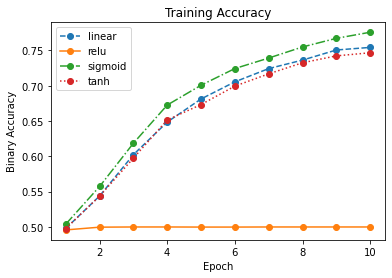

In [7]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=dense_activation_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

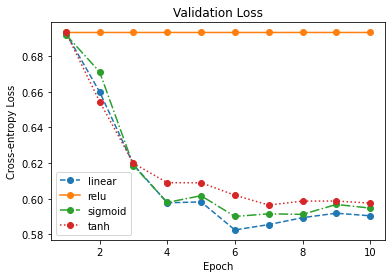

In [8]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=dense_activation_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

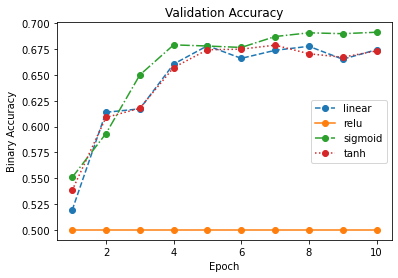

In [9]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=dense_activation_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked dropout_rate

In [35]:
def dropout_label(t, hp):
    return hp.get("Bert.dropout_rate")


# batch_size=8, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dropout_rate=0.1
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/dropout_rate",
    trial_aggregator=lambda hp: hp.get("Bert.dropout_rate"),
    trial_filterer=lambda t, hp: hp.get("Bert.dropout_rate") < 0.5,
)

Text(0.5, 1.0, 'Training Loss')

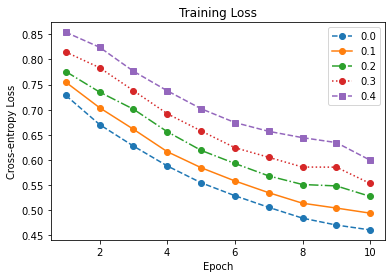

In [36]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=dropout_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

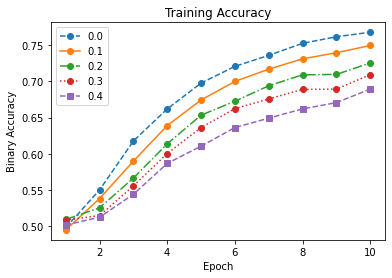

In [37]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=dropout_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

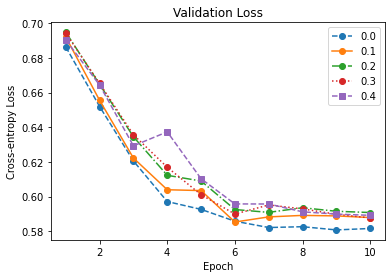

In [38]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=dropout_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

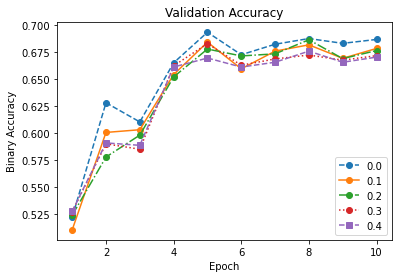

In [39]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=dropout_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

### BERT chunked number of linear layers

In [30]:
def num_hidden_layers_label(t, hp):
        return f"{hp.get('Bert.num_hidden_layers')} layers{' with BatchNorm' if hp.get('Bert.use_batch_norm') else ''}"

    
# batch_size=8, dropout_rate=0.1, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dense_hidden_activation=relu
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/ffnn_relu_batch_norm",
)

Text(0.5, 1.0, 'Training Loss')

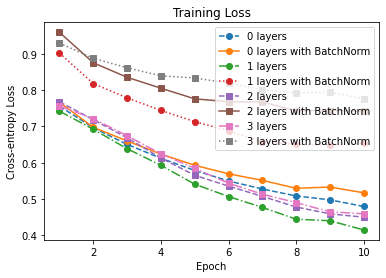

In [31]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

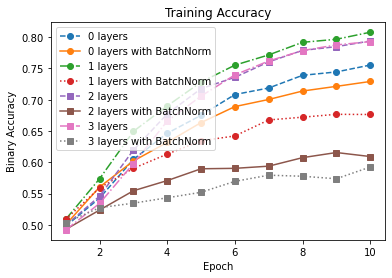

In [32]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

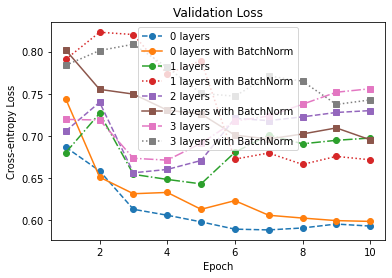

In [33]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

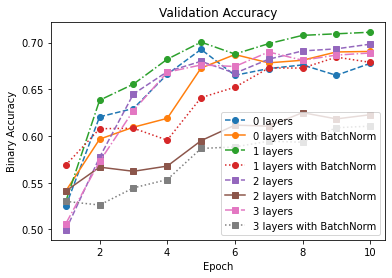

In [34]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")

In [35]:
def num_hidden_layers_label(t, hp):
        return f"{hp.get('Bert.num_hidden_layers')} layers{' with BatchNorm' if hp.get('Bert.use_batch_norm') else ''}"

    
# batch_size=8, dropout_rate=0.1, pooling strategy=sum_last_4_hidden_layers, pooler=concat, 
# preprocessing=[remove_emojis, remove_tags], learning_rate=2e-5, dense_hidden_activation=linear
data, num_epochs = fetch_and_aggregate_experiment_data(
    "../../training/bert_clf/downstream_loss/ffnn_linear_batch_norm",
)

Text(0.5, 1.0, 'Training Loss')

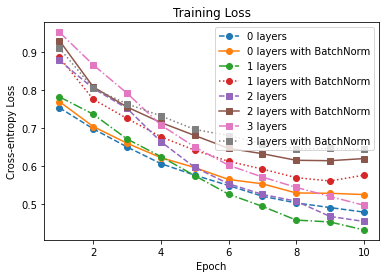

In [36]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_loss", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

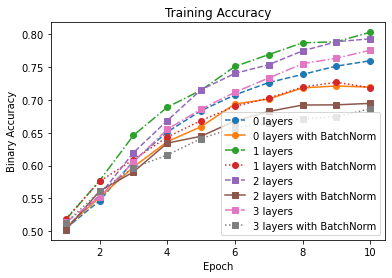

In [37]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "train-epoch_binary_accuracy", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Binary Accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Validation Loss')

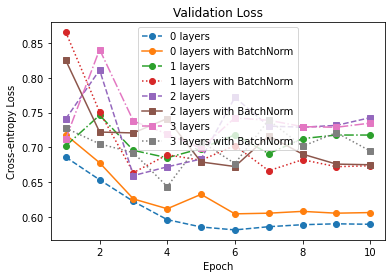

In [38]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_loss", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Cross-entropy Loss")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Accuracy')

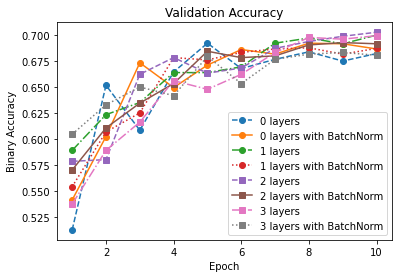

In [39]:
# plt.figure(figsize=(8, 6), dpi=300)
plot_data(data, num_epochs, "validation-epoch_binary_accuracy", trial_label_generator=num_hidden_layers_label)
plt.ylabel("Binary Accuracy")
plt.title("Validation Accuracy")